# Building a 5-fold nested cross-validation k-nearest neighbor classifier 

The purpose of this project is to get more familiar with a very common machine learning classifier (k-nearest neighbor) by engineering it from scratch, without using any prebuilt libraries. This will include parameter selection and model evaluation.

A common problem when using any classifier is overfitting the training data. To overcome this, we will implement 5-fold nested cross-validation.

Note: This project is purposely light on data analysis and heavy on engineering, as its purposes is to understand k-NN classification. For audiences not familiar with the k-NN classifier or evaluation metrics, I would recommend the following as a brief introduction: https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ 

## 1. Loading the Data

This project will use the **Wine** dataset. This is a 178 sample dataset that categorizes 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features to work with.

In [29]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# choose a subset of features
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

## 2. Quick Data Exploration 

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at hand. When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features.

A scatterplot grid will be generated to visualize the relationship between the selected features in the Wine dataset. The on-diagonal subplots (representing a single feature) show a histogram for that feature. The off-diagonal subplot shows the interaction between two features, and each of the classes represented as a different colour. 

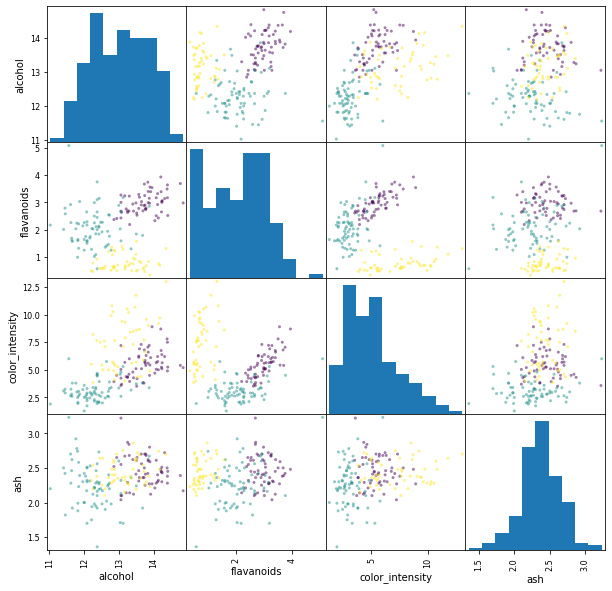

In [30]:
df = pd.DataFrame(X, columns=selected_features)
scatter_matrix(df, alpha = 0.5, figsize = (10, 10), diagonal = 'hist', c=y); 

The scatter plots show that for most of the feature comparisons, the classes are fairly clustered together. Because knn depends on distance between class items for accurate classification, the less distance between class items the less accurately we might expect the algorithm to classify items.

The most separation can be seen between color intensity and flavanoids. If, for example, we restricted our dataset to just these 2 features, these would be the best ones to select.

### Adding in Noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. 

Therefore we will add some Gaussian noise and see the effect on the dataset.

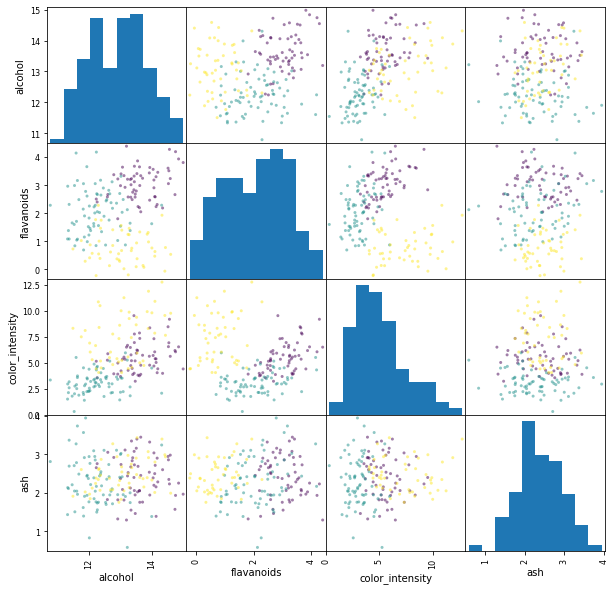

In [31]:
# initialize random seed to replicate results over different runs
seed = 12345 
np.random.seed(seed) 
XN = X + np.random.normal(0, 0.5, X.shape)
dfn = pd.DataFrame(XN, columns=selected_features)

scatter_matrix(dfn, alpha = 0.5, figsize = (10, 10), diagonal = 'hist', c=y); 

Taking color intensity and flavanoids, the scatter plots with noise show more diffusion in the location of class items. In other words, the average distance between class items appears to be reduced. 

The expectation would then be that the classifier's accuracy would be slightly diminished. Interestingly, this was not born out in the results below. This may be because across most of the features, as noted above, the classes were fairly clustered to begin with. This coud also be the result of how accuracy per fold was evaluated, as noted below.

## 2. Implementing kNN

In [32]:
# helper functions

def test_train_split(X, y, test_size):
    '''Splits dataset into training and testing subsets'''

    test_size = round(len(X) * test_size)
    index = np.arange(0, len(X))
    testix = np.random.choice(len(index), test_size, replace=False)
    trainix = [x for x in index if x not in testix]
    
    X_test, X_train = X[testix], X[trainix]
    y_test, y_train = y[testix], y[trainix]
    
    return X_train, X_test, y_train, y_test    
    
def dist(vec1, vec2, metric):
    '''Calculates the Euclidean or Manhattan distance between vec1 and vec2'''
    
    assert metric == 'euclidean' or 'manhattan', "Distance metric must be Euclidean or Manhattan"
    
    if metric == 'euclidean':
        dist = np.linalg.norm(vec1 - vec2)
    if metric == 'manhattan':
        dist = sum(abs(val1-val2) for val1, val2 in zip(vec1,vec2))
    return dist

def mode(List):
    '''Calculates the mode of a list'''
    return max(set(list(List)), key = list(List).count)

def nearest_neighbors(vec, X_train, k, metric):
    '''Calculates the index position of the nearest neighbor(s) to the given vector'''
    
    assert k > 0, 'k must be a whole number'
    assert k - int(k) == 0, 'k must be a whole number'
    assert k < len(X_train) + 1, 'k cannot exceed the size of the training data'
    
    # build a dict recording the distance between
    # the given vector and all others in the dataset
    dist_dict = {}
    for i in range(len(X_train)):
        if np.array_equal(vec, X_train[i]) != True:    # exclude vector's distance to itself
            dist_dict[i] = dist(vec, X_train[i], metric)
      
        # sort the dict by distances
        dict_sorted = dict(sorted(dist_dict.items(), key=lambda item: item[1]))
        
        # create list of the sorted indices comprising only the first k items
        nearest = list(dict_sorted)[:k]

    return nearest

def knn(X_train, X_test, y_train, y_test, k, metric):
    '''Predicts labels for X_test values based on nearest neighbor(s)'''
    
    y_pred = np.zeros(y_test.shape, dtype=int) 

    for i in range(len(X_test)):
        index = nearest_neighbors(X_test[i], X_train, k, metric)
        label = y_train[index]

        # find the most frequent label among the nearest neighbors
        if k > 1:
            label = mode(label)

        y_pred[i] = label 
        
    return y_pred

## 3. Classifier evaluation

Finally we will create functions to evaluate the accuracy of our results.

In [33]:
def confmat(y_test, y_pred):
    '''Generates a confusion matrix of y_pred against y_test'''
    
    confmat = np.zeros((3,3), dtype=int)
    
    for val,pred in zip(y_test, y_pred):
        confmat[val,pred] += 1
   
    return confmat

def accuracy(y_test, y_pred):
    '''Calculates the accuracy of y_pred values against y_test'''
    
    correct = 0
    
    for i in range(len(y_test)):
        correct += np.where(y_test[i]==y_pred[i], 1, 0)

    return correct/len(y_test)

In [34]:
# generate some example results to test against
X_train, X_test, y_train, y_test = test_train_split(X, y, 0.2)   
y_pred = knn(X_train, X_test, y_train, y_test, 5, 'euclidean')

print(accuracy(y_test,y_pred))

#note: len(np.unique(y)) indicates the dimensions of the confusion matrix (why?)
print(confmat(y_test,y_pred))

0.9444444444444444
[[10  0  0]
 [ 2  9  0]
 [ 0  0 15]]


In [35]:
# test results against those given by the sklearn functions to ensure they match

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.9444444444444444
[[10  0  0]
 [ 2  9  0]
 [ 0  0 15]]


## 4. Nested Cross-validation 

Below comes the most complicated part, developing code to perform 5-fold nested cross-validation along with our implemenation of k-NN above. 

We will: 
- perform nested cross-validation on both our original data X, as well as the data perturbed by noise as shown in the cells above (XN)
- evaluate 2 different distance functions
- evaluate number of neighbours from 1 to 10
- return a list of accuracies per fold
- for each **fold**, print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [36]:
def nestedCrossVal(X, y, folds, k_vals, metrics, indices, seed):
    '''Return the best performing hyperparameters per fold with the given k-values and distance metric'''
    
    index = np.arange(0,len(X))

    # create arrays to store values to be returned by function
    fold_scores = np.empty(shape=(0, 3))
    conf_matrices = np.empty(shape=(0, 3), dtype=int)
    
    # folds
    for fold in range(folds):
        print('Processing fold {} of {}...'.format(fold+1, folds))
        
        # test / train split in the fold
        testix = indices[fold]
        trainix = [x for x in index if x not in testix]
        X_test, X_train = X[testix], X[trainix]
        y_test, y_train = y[testix], y[trainix]

        # train / validation split to be used in the loops
        val_size = 0.25
        val_size = round(len(X) * val_size)
        loop_index = np.arange(0, len(trainix))
        loop_valix = np.random.choice(len(trainix), val_size, replace=False)
        loop_trainix = [x for x in trainix if x not in loop_valix]
        X_val, X_train = X[loop_valix], X[loop_trainix]
        y_val, y_train = y[loop_valix], y[loop_trainix]
        
        # calculate number of parameter permutations, i.e. how many inner loops will be run
        loops = len(k_vals) * len(metrics)
        
        # create an array to store the coming accuracy scores of the loop hyperparameters
        loop_scores = np.empty(shape=(0, 3))

        # inner loops
        for k_val in k_vals:
            for metric in metrics:
                
                # calculate knn's predicted values and determine the accuracy 
                y_pred = knn(X_train, X_val, y_train, y_val, k_val, metric)
                score = accuracy(y_val,y_pred)
                print('accuracy = {} for k = {} and distance = {}'.format(score, k_val, metric))
                
                # add the k-val, metric and accuracy score to scores array          
                new_row = np.array([[k_val,metric,score]])
                loop_scores = np.concatenate((loop_scores, new_row), axis=0)

        # evaluate the winning hyperparameters
        high_score = max(loop_scores[:, 2])
        winner = np.argwhere(loop_scores==high_score)[0]
        winner = loop_scores[winner[0]]
        k_winner = winner[0]
        m_winner = winner[1]
        
        # record the fold's winning values
        new_row = np.array([[k_winner,m_winner,high_score]])
        fold_scores = np.concatenate((fold_scores, new_row), axis=0)
        print("With a score of {}, this fold's winners are k={} and distance={}".format(high_score, k_winner, m_winner))
        
        # generate a set of y_pred from the winning parameters again, so its confusion matrix can be shown
        y_pred = knn(X_train, X_test, y_train, y_test, k_val, metric)
        
        print("Confusion matrix:\n", confmat(y_test,y_pred), "\n")
        
        new_row = np.array(confmat(y_test,y_pred))
        conf_matrices = np.concatenate((conf_matrices, new_row), axis=0)
                
    # evaluate the winning parameters    
    fold_scores = fold_scores[:, 2].astype(float)

    return fold_scores, conf_matrices

In [37]:
# evaluate clean data

# generate the fold indices
folds = 5
np.random.seed(seed)
indices = np.random.permutation(np.arange(0,len(X),1))
indices = np.array_split(indices, folds) 

folds_clean, conf_matrices_clean = nestedCrossVal(X,y,folds,list(range(1,11)), ['euclidean','manhattan'], indices, seed)

Processing fold 1 of 5...
accuracy = 0.8863636363636364 for k = 1 and distance = euclidean
accuracy = 0.8636363636363636 for k = 1 and distance = manhattan
accuracy = 0.8863636363636364 for k = 2 and distance = euclidean
accuracy = 0.8636363636363636 for k = 2 and distance = manhattan
accuracy = 0.8636363636363636 for k = 3 and distance = euclidean
accuracy = 0.8863636363636364 for k = 3 and distance = manhattan
accuracy = 0.8636363636363636 for k = 4 and distance = euclidean
accuracy = 0.8636363636363636 for k = 4 and distance = manhattan
accuracy = 0.8636363636363636 for k = 5 and distance = euclidean
accuracy = 0.8636363636363636 for k = 5 and distance = manhattan
accuracy = 0.8409090909090909 for k = 6 and distance = euclidean
accuracy = 0.8636363636363636 for k = 6 and distance = manhattan
accuracy = 0.8636363636363636 for k = 7 and distance = euclidean
accuracy = 0.8636363636363636 for k = 7 and distance = manhattan
accuracy = 0.8409090909090909 for k = 8 and distance = euclidean

In [38]:
# evaluate noisy data

# generate the fold indices
folds = 5
np.random.seed(seed)
indices = np.random.permutation(np.arange(0,len(X),1))
indices = np.array_split(indices, folds) 

folds_noisy, conf_matrices_noisy = nestedCrossVal(XN,y,folds,list(range(1,11)), ['euclidean', 'manhattan'], indices, seed)

Processing fold 1 of 5...
accuracy = 0.8181818181818182 for k = 1 and distance = euclidean
accuracy = 0.8409090909090909 for k = 1 and distance = manhattan
accuracy = 0.8181818181818182 for k = 2 and distance = euclidean
accuracy = 0.8409090909090909 for k = 2 and distance = manhattan
accuracy = 0.8863636363636364 for k = 3 and distance = euclidean
accuracy = 0.9318181818181818 for k = 3 and distance = manhattan
accuracy = 0.8409090909090909 for k = 4 and distance = euclidean
accuracy = 0.8409090909090909 for k = 4 and distance = manhattan
accuracy = 0.9090909090909091 for k = 5 and distance = euclidean
accuracy = 0.9545454545454546 for k = 5 and distance = manhattan
accuracy = 0.8636363636363636 for k = 6 and distance = euclidean
accuracy = 0.9090909090909091 for k = 6 and distance = manhattan
accuracy = 0.9545454545454546 for k = 7 and distance = euclidean
accuracy = 0.9090909090909091 for k = 7 and distance = manhattan
accuracy = 0.9318181818181818 for k = 8 and distance = euclidean

## 5. Summary of results 

### 5.1. Accuracy

In [41]:
# cheat code for the tables below

# clean
print('Clean \n' + 'Mean:', np.mean(folds_clean))
print('Standard deviation:', round(np.std(folds_clean), 5))

# noisy
print('\n' + 'Noisy \n' + 'Mean:', np.mean(folds_noisy))
print('Standard deviation:', round(np.std(folds_noisy), 5))

Clean 
Mean: 0.9363636363636363
Standard deviation: 0.03636

Noisy 
Mean: 0.9409090909090908
Standard deviation: 0.02318


**Clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.8864  |  1 | euclidean  |
| 2 | 0.9773  |  3 | euclidean  |
| 3 | 0.9773  |  2 | euclidean  |
| 4 | 0.9318  |  1 | euclidean  |
| 5 | 0.9091  |  1 | manhattan  |
| **Average** | 0.9364 $\pm$ 0.0364 |


**Noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.9545  |  5 | manhattan  |
| 2 | 0.9318  |  2 | euclidean  |
| 3 | 0.9091  |  10 | euclidean  |
| 4 | 0.9773  |  7 | euclidean  |
| 5 | 0.9318  |  4 | manhattan  |
| **Average** | 0.9409 $\pm$ 0.0232 |   |    |


<br>
For the clean data, the two parameter combinations yielding the highest accuracy (0.9773) were k = 1 or 2 and distance = euclidean. We can also see the k values tended to be low while the distance metrics tended to be euclidean across folds.

For the noisy data, the parameter combination with the highest accuracy of 0.9773 was k = 5 and distance = manhattan. Clearly, quite different results. Optimal k values and distance metrics were fairly evenly distributed across folds, with no clear pattern between folds as there was in the clean data.

Therefore, it appears the optimal parameters *did* vary by the input data. This is a somewhat intuitive finding. If the optical parameters didn't vary by the dataset, then they wouldn't need to be optimized for each dataset. 

Having said that, the algorithm could have been better. The optimal parameters per fold were chosen as simply the first instance of the highest accuracy. Since low values of k were run first and euclidean was tested before manhattan, these parameters were slightly favored in the above results. 

### 5.2. Confusion matrix 

In [19]:
# clean data summary results

confmat1 = conf_matrices_clean[0:3]; confmat2 = conf_matrices_clean[3:6];
confmat3 = conf_matrices_clean[6:9]; confmat4 = conf_matrices_clean[9:12]
confmat5 = conf_matrices_clean[12:15]
confmat_total = confmat1 + confmat2 + confmat3 + confmat4 + confmat5

clean = pd.DataFrame(confmat_total)
clean.index = pd.Index(clean.index, name='true')
clean.columns = pd.Index(clean.columns, name='predicted')

print('Clean Data Overall Confusion Matrix\n')
print(clean)

# noisy data summary results

confmat1 = conf_matrices_noisy[0:3]; confmat2 = conf_matrices_noisy[3:6]
confmat3 = conf_matrices_noisy[6:9]; confmat4 = conf_matrices_noisy[9:12]
confmat5 = conf_matrices_noisy[12:15]
confmat_total = confmat1 + confmat2 + confmat3 + confmat4 + confmat5

noisy = pd.DataFrame(confmat_total)
noisy.index = pd.Index(clean.index, name='true')
noisy.columns = pd.Index(clean.columns, name='predicted')

print('\n\nNoisy Data Overall Confusion Matrix\n')
print(noisy)

Clean Data Overall Confusion Matrix

predicted   0   1   2
true                 
0          59   0   0
1          10  59   2
2           0   0  48


Noisy Data Overall Confusion Matrix

predicted   0   1   2
true                 
0          53   5   1
1           3  67   1
2           0   1  47
